# **ĐỒ ÁN CUỐI KÌ DS301.**

GẮN NHẴN TỪ LOẠI TRÊN BỘ DỮ LIỆU VSLP NĂM 2013.

- Trong phần này chúng tôi sẽ sử dụng một model embedding được xây dựng sẵn có tên là FastText_ner.
https://github.com/vietnlp/etnlp



In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# PHẦN 1. Pre-trained Embedding.

In [2]:
word_dict = []
embeddings_index = {}
embedding_dim = 300
max_feature = len(embeddings_index) + 2

f = open('/content/drive/MyDrive/Đồ Án DS310/Word_EmBedding/FastText_ner.vec')
for line in f:
    values = line.split(' ')
    word = values[0] 
    word_dict.append(word)
    try:
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    except Exception as e:
        pass
f.close()

print('Embedding data loaded')

Embedding data loaded


- Tạo bộ chỉ mục.

In [3]:
words = word_dict
num_words = len(words)+2
# Dictionary word:index pair
# word is key and its value is corresponding index
word2idx = {w : i + 2 for i, w in enumerate(words)}
word2idx["UNK"] = 1
word2idx["PAD"] = 0
# Dictionary lable:index pair
idx2word = {i: w for w, i in word2idx.items()}

- Với model này là tập các từ vựng đều ở dạng chữ viết thường. Cho nên qua trình xử lý dữ liệu ta sữ chuyển về dạng chữ thường.

In [4]:
embedding_dim=300
import numpy as np
# first create a matrix of zeros, this is our embedding matrix
embedding_matrix = np.zeros((num_words, embedding_dim))

# for each word in out tokenizer lets try to find that work in our w2v model
for word,i in word2idx.items():
    if  i> max_feature:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
    else:
        # doesn't exist, assign a random vector
        embedding_matrix[i] = np.random.randn(embedding_dim)

In [5]:
print("Embeddings shape: {}".format(embedding_matrix.shape))

Embeddings shape: (15977, 300)


#PHẦN 2: TIỀN XỬ LÝ DỮ LIỆU.

## Bước 1: Đọc dữ liệu.

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
from io import BytesIO
import pandas as pd
import numpy as np
import requests
import seaborn as sns
np.random.seed(0)
plt.style.use("ggplot")
import tensorflow as tf

In [7]:
# data_train.
df_train=pd.read_csv("/content/drive/MyDrive/Đồ Án DS310/data/VLSP2013-POS-data/VLSP2013_POS_train_BI_POS_Column.txt",
                     sep='\t',header=None,encoding='UTF-8', error_bad_lines=False,skip_blank_lines=False)
# Đổi tên các cột.
df_train.columns = ('Words','Tags')
# Đưa về dạng chữ thường.
df_train["Words"]=df_train["Words"].str.lower()

In [8]:
# data_test.
df_test=pd.read_csv("/content/drive/MyDrive/Đồ Án DS310/data/VLSP2013-POS-data/VLSP2013_POS_test_BI_POS_Column.txt",
                     sep='\t',header=None,encoding='UTF-8', error_bad_lines=False,skip_blank_lines=False)
df_test.columns = ('Words','Tags')
df_test["Words"]=df_test["Words"].str.lower()

In [9]:
# data_dev.
df_dev=pd.read_csv("/content/drive/MyDrive/Đồ Án DS310/data/VLSP2013-POS-data/VLSP2013_POS_dev_BI_POS_Column.txt",
                     sep='\t',header=None,encoding='UTF-8', error_bad_lines=False,skip_blank_lines=False)
df_dev.columns = ('Words','Tags')
df_dev["Words"]=df_dev["Words"].str.lower()

In [10]:
df_train.head()

Words Tags
0  hải_tặc    N
1  eo_biển    N
2  malacca   Np
3        (   CH
4       kỳ    N

## Bước 2: Phân chia các câu.


### Vấn đề đặt ra.
Các câu sẽ được chia dựa vào xuống dòng để kết thúc mỗi câu. Vì vậy ta sẽ sử dụng hàm để gắn nhãn theo ý tưởng của hàm sau đây


In [11]:
lis=[4,6,9]
def list_sentence(lis):
  arr=[0]
  x=0
  y=0
  for i in range(len(lis)):
    for j in range(int(lis[i]-y)):
      arr.append(x)
    x+=1
    y=lis[i]
  return arr

list_sentence(lis)

[0, 0, 0, 0, 0, 1, 1, 2, 2, 2]

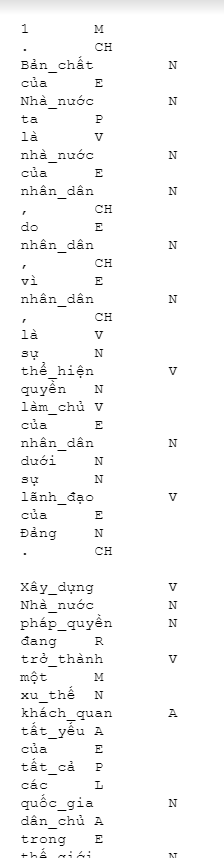

In [12]:
df_test[20:40]

Words Tags
20       quyền    N
21     làm_chủ    V
22         của    E
23    nhân_dân    N
24        dưới    N
25          sự    N
26    lãnh_đạo    V
27         của    E
28        đảng    N
29           .   CH
30         NaN  NaN
31    xây_dựng    V
32    nhà_nước    N
33  pháp_quyền    N
34        đang    R
35   trở_thành    V
36         một    M
37      xu_thế    N
38  khách_quan    A
39     tất_yếu    A

### Tiến hành xử lý gắn câu.

- Gắn câu cho tập train.

In [13]:
# Tìm các index là NaN ở ô tags.
list_index=df_train[df_train['Tags'].isnull()].index
# Tìm list các số thứ tự câu
list_sentences=list_sentence(list_index)
# Gắn vào data.
df_train['Sentences']= list_sentences
# Xóa nhưng cốt xuống dòng dừa các câu.
df_train.drop(list_index, inplace=True)

- Gắn câu cho tập dev.

In [14]:
# Tìm các index là NaN ở ô tags.
list_index=df_dev[df_dev['Tags'].isnull()].index
# Tìm list các số thứ tự câu
list_sentences=list_sentence(list_index)
# Gắn vào data.
df_dev['Sentences']= list_sentences
# Xóa nhưng cốt xuống dòng dừa các câu.
df_dev.drop(list_index, inplace=True)

- Gắn câu cho tập test.

In [15]:
# Tìm các index là NaN ở ô tags.
list_index=df_test[df_test['Tags'].isnull()].index
# Tìm list các số thứ tự câu
list_sentences=list_sentence(list_index)
# Gắn vào data.
df_test['Sentences']= list_sentences
# Xóa nhưng cốt xuống dòng dừa các câu.
df_test.drop(list_index, inplace=True)

In [16]:
df_test

Words Tags  Sentences
0             1    M          0
1             .   CH          0
2      bản_chất    N          0
3           của    E          0
4      nhà_nước    N          0
...         ...  ...        ...
68460       vào    E       2119
68461  đời_sống    N       2119
68462  một_cách    R       2119
68463  hệ_thống    N       2119
68464         .   CH       2119

[66346 rows x 3 columns]

## Bước 3: Kiểm tra bộ dữ liệu.

In [17]:
# Kiểm tra kích thước.
print(df_dev.shape)
print(df_test.shape)
print(df_train.shape)

(22823, 3)
(66346, 3)
(608960, 3)


### Xử lý sai sót.


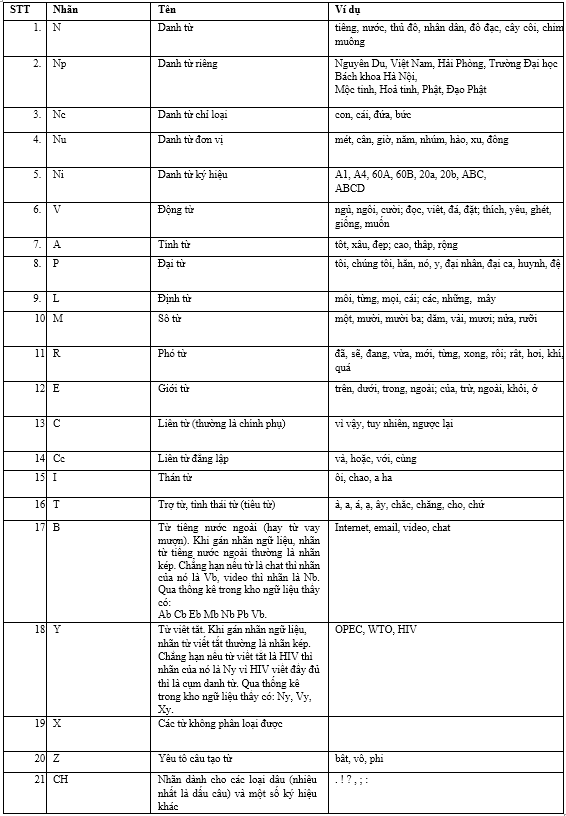

In [18]:
# Kiểm tra số lượng nhãn.
print((df_dev['Tags'].nunique()))
print((df_test['Tags'].nunique()))
print((df_train['Tags'].nunique()))

20
21
32


Do ở tập test

- Chúng ta có trong phần mô tả là 21 nhãn của thuộc tính tags. Những phần nhãn 'Y' có thể được chia ra thành các nhãn nhỏ khác nhau vì thế ở tập train ta có tận 32 nhãn vì vậy chúng ta sẽ format lại về nhãn Y.

#### Xử lý tags trên tập train.

In [19]:
# Kiểm tra nhãn tập train.
df_train['Tags'].unique()

array(['N', 'Np', 'CH', 'M', 'R', 'A', 'P', 'V', 'Nc', 'E', 'L', 'C',
       'Ny', 'T', 'Nb', 'Y', 'Nu', 'Cc', 'Vb', 'I', 'X', 'Z', 'B', 'Eb',
       'Vy', 'Ab', ',', 'Cb', 'Mb', 'Pb', 'Ni', 'Xy'], dtype=object)

- Nhận thấy trong qua trình gắn nhãn bị sai ở cột tag.

In [20]:
# Phát hiện sai nhãn ở tập train.
df_train.loc[df_train["Tags"]==',']

Words Tags  Sentences
89396     ,    ,       3897

- Do chỉ sai ở 1 ô và đây là dấu ',' vì thế ta sẽ gắn nhãn lại tag "CH" ở đây.

In [21]:
df_train["Tags"].replace(',','CH',inplace=True)

- Bây giờ ta đã có một tập train gồm các tag đầy đủ.

In [22]:
print((df_train['Tags'].nunique()))

31


In [23]:
df_train['Tags'].unique()

array(['N', 'Np', 'CH', 'M', 'R', 'A', 'P', 'V', 'Nc', 'E', 'L', 'C',
       'Ny', 'T', 'Nb', 'Y', 'Nu', 'Cc', 'Vb', 'I', 'X', 'Z', 'B', 'Eb',
       'Vy', 'Ab', 'Cb', 'Mb', 'Pb', 'Ni', 'Xy'], dtype=object)

- Format lại các tags.

In [24]:
# format nhãn B.
df_train['Tags'].replace(['Ab', 'Cb','Eb','Mb','Nb','Pb','Vb'], 
                         ['B','B','B','B','B','B','B'], inplace=True)
# format nhãn Y.
df_train['Tags'].replace(['Ny', 'Vy','Xy'], 
                         ['Y','Y','Y'], inplace=True)

In [25]:
print("Số nhãn tags trên tập train: ",df_train['Tags'].nunique())
df_train['Tags'].unique()

Số nhãn tags trên tập train:  21


array(['N', 'Np', 'CH', 'M', 'R', 'A', 'P', 'V', 'Nc', 'E', 'L', 'C', 'Y',
       'T', 'B', 'Nu', 'Cc', 'I', 'X', 'Z', 'Ni'], dtype=object)

#### Kiểm tra trên 2 tập còn lại.

In [26]:
# format nhãn B.
df_dev['Tags'].replace(['Ab', 'Cb','Eb','Mb','Nb','Pb','Vb'], 
                         ['B','B','B','B','B','B','B'], inplace=True)
# format nhãn Y.
df_dev['Tags'].replace(['Ny', 'Vy','Xy'], 
                         ['Y','Y','Y'], inplace=True)

# format nhãn B.
df_test['Tags'].replace(['Ab', 'Cb','Eb','Mb','Nb','Pb','Vb'], 
                         ['B','B','B','B','B','B','B'], inplace=True)
# format nhãn Y.
df_test['Tags'].replace(['Ny', 'Vy','Xy','NY'], 
                         ['Y','Y','Y','Y'], inplace=True)

In [27]:
df_dev['Tags'].nunique()

19

In [28]:
df_test['Tags'].unique()

array(['M', 'CH', 'N', 'E', 'P', 'V', 'R', 'A', 'L', 'Cc', 'X', 'Np',
       'Nc', 'C', 'T', 'Y', 'Ni', 'Z', 'I', 'Nu'], dtype=object)

- Kiểm tra lại cuối cùng.

In [29]:
print((df_dev['Tags'].nunique()))
print((df_test['Tags'].nunique()))
print((df_train['Tags'].nunique()))

19
20
21


### Xử lý missing.

In [30]:
df_train[df_train['Words'].isnull()]

Words Tags  Sentences
257911   NaN    N      11509
304459   NaN    N      13439
310763   NaN    N      13693
310930   NaN    N      13701

- Sau khi kiểm tra ở bộ dữ liệu. Ta nhận thấy có chút nhầm lẫn khi đọc dữ liệu ở đây là. Từ "nan" trong tiếng việt, ví dụ như "nan hoa", "nan tre" bị hiểu nhầm là giá trị null. Vì thế ta cần đổi lại cho phù hợp.

In [31]:
df_dev=df_dev.fillna('nan')

In [32]:
df_train=df_train.fillna('nan')

- Kiểm tra lại sau khi điền giá trị null.

In [33]:
df_train.isnull().sum()

Words        0
Tags         0
Sentences    0
dtype: int64

In [34]:
df_dev.isnull().sum()

Words        0
Tags         0
Sentences    0
dtype: int64

In [35]:
df_test.isnull().sum()

Words        0
Tags         0
Sentences    0
dtype: int64

=> Dữ liệu đã ở dạng hoàn hảo.

## Bước 4: Lấy các câu theo các thẻ tương ứng.

In [36]:
class SentenceGetter(object):
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, t) for w, t in zip(s["Words"].values.tolist(),
                                                           s["Tags"].values.tolist())]
        self.grouped = self.data.groupby("Sentences").apply(agg_func)
        self.sentences = [s for s in self.grouped]

In [37]:
getter_train = SentenceGetter(df_train)
getter_test = SentenceGetter(df_test)
getter_Dev = SentenceGetter(df_dev)
sentences_train = getter_train.sentences
sentences_test = getter_test.sentences
sentences_dev = getter_Dev.sentences

In [38]:
# Thử đọc 1 câu.
sentences_train[0]

[('hải_tặc', 'N'),
 ('eo_biển', 'N'),
 ('malacca', 'Np'),
 ('(', 'CH'),
 ('kỳ', 'N'),
 ('1', 'M'),
 (')', 'CH'),
 (':', 'CH'),
 ('eo_biển', 'N'),
 ('không', 'R'),
 ('yên_tĩnh', 'A'),
 ('...', 'CH')]

## Bước 5: Tạo danh sách word và tag dựa vào tập train và tập dev.

In [39]:
print(words)
print(num_words)

['15974', '!', '"', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '..', '...', '....', '/', '0', '0,04%', '0,5', '0,6', '0,7%', '01', '018', '019', '04', '091', '1', '1%', '1,1', '1,2', '1,3', '1,4', '1,5', '1,58', '1,6', '1,60', '1,61', '1,7', '1,70', '1,8', '1,80', '1,85', '1,9', '1-12', '1-1967', '1-2', '1-2004', '1.000', '1.000.000', '1.001', '1.040', '1.090', '1.100', '1.130', '1.140', '1.150', '1.200', '1.223', '1.275', '1.300', '1.320', '1.393', '1.400', '1.459', '1.500', '1.600', '1.619', '1.634', '1.677', '1.800', '1.855', '1.870', '1.900', '1/3', '10', '10%', '10-10', '10-2005', '10-5', '10-6', '10-8', '10-9', '10.000', '10.036', '100', '100%', '100.000', '101', '102.000', '105', '106', '108', '1080', '109', '1099', '11', '11,9', '11-10', '11-2005', '11.000', '11.200', '110', '110.000', '111', '112', '115', '11a', '12', '12%', '12,4%', '12,5', '12,8', '12-1949', '12-2004', '12.000', '12.500', '120', '120.000', '123', '125', '126', '128', '12v', '13', '13-11', '13-7', '13.

In [40]:
tags_1 = list(set(df_train["Tags"].values))
tags_2 = list(set(df_dev["Tags"].values))
tags_3 = list(set(df_test["Tags"].values))
tags = list(set(tags_1+tags_2+tags_3))
num_tags = len(tags)
tags.append("O")
print(tags)
print(num_tags)

['Np', 'C', 'N', 'Cc', 'B', 'Nu', 'R', 'E', 'T', 'Ni', 'X', 'V', 'CH', 'L', 'P', 'M', 'I', 'Z', 'A', 'Nc', 'Y', 'O']
21


## Bước 6: Ánh xạ các từ và chỉ mục.

In [41]:

tag2idx = {t: i for i, t in enumerate(tags)}


In [42]:
# word2idx
# word2idx["ENDPAD"]
tag2idx 

{'A': 18,
 'B': 4,
 'C': 1,
 'CH': 12,
 'Cc': 3,
 'E': 7,
 'I': 16,
 'L': 13,
 'M': 15,
 'N': 2,
 'Nc': 19,
 'Ni': 9,
 'Np': 0,
 'Nu': 5,
 'O': 21,
 'P': 14,
 'R': 6,
 'T': 8,
 'V': 11,
 'X': 10,
 'Y': 20,
 'Z': 17}

## Bước 7: Padding đầu vào dữ liệu, Và mã hóa dữ liệu đầu ra.

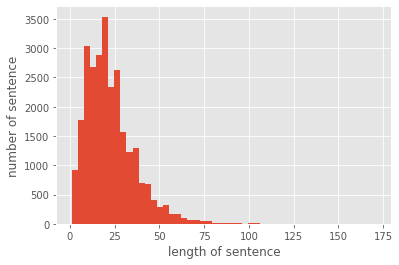

In [43]:
plt.hist([len(s) for s in sentences_train], bins=50)
plt.xlabel("length of sentence")
plt.ylabel('number of sentence')
plt.show()

In [44]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import  to_categorical
max_len = 75
NUM_LABEL = 3
# Xây dựng hàm mã hóa.
def encoding(data):
  X=[]
  for s in data:
    sent=[]
    for w in s:
      try:
        sent.append(word2idx[w[0]])
      except:
        sent.append(word2idx["UNK"])
    X.append(sent)

  X = pad_sequences(maxlen=max_len, sequences=X, padding="post", value=0)
  y=[[tag2idx[w[1]] for w in s] for s in data]
  y=pad_sequences(maxlen=max_len, sequences=y, padding="post",value=num_tags)
  y= to_categorical(y)
  return (X,y)

In [45]:
X_train, y_train = encoding(sentences_train)
X_dev, y_dev = encoding(sentences_dev)
X_test, y_test = encoding(sentences_test)

In [46]:
print("TRAINING DATA")
print('Shape of input sequences: {}'.format(X_train.shape))
print('Shape of output sequences: {}'.format(y_train.shape))
print("-"*50)
print("VALIDATION DATA")
print('Shape of input sequences: {}'.format(X_dev.shape))
print('Shape of output sequences: {}'.format(y_dev.shape))
print("-"*50)
print("TESTING DATA")
print('Shape of input sequences: {}'.format(X_test.shape))
print('Shape of output sequences: {}'.format(y_test.shape))

TRAINING DATA
Shape of input sequences: (26999, 75)
Shape of output sequences: (26999, 75, 22)
--------------------------------------------------
VALIDATION DATA
Shape of input sequences: (871, 75)
Shape of output sequences: (871, 75, 22)
--------------------------------------------------
TESTING DATA
Shape of input sequences: (2120, 75)
Shape of output sequences: (2120, 75, 22)


In [47]:
X_test[1]

array([ 5453,  3507,     1, 14832,  4860,  3126, 14401,  8746, 13708,
        1648,  5050,  1470,  3992,  7464,  4713,  4555,  8147,    14,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0], dtype=int32)

# PHẦN 3: XÂY DỰNG MODEL POS TAGGING DỰA VÀO CÁC THUẬT TOÁN.

- Kiểm tra lại tập dữ liệu đầu vào và đầu ra.

In [48]:
print("TRAINING DATA")
print('Shape of input sequences: {}'.format(X_train.shape))
print('Shape of output sequences: {}'.format(y_train.shape))
print("-"*50)
print("VALIDATION DATA")
print('Shape of input sequences: {}'.format(X_dev.shape))
print('Shape of output sequences: {}'.format(y_dev.shape))
print("-"*50)
print("TESTING DATA")
print('Shape of input sequences: {}'.format(X_test.shape))
print('Shape of output sequences: {}'.format(y_test.shape))

TRAINING DATA
Shape of input sequences: (26999, 75)
Shape of output sequences: (26999, 75, 22)
--------------------------------------------------
VALIDATION DATA
Shape of input sequences: (871, 75)
Shape of output sequences: (871, 75, 22)
--------------------------------------------------
TESTING DATA
Shape of input sequences: (2120, 75)
Shape of output sequences: (2120, 75, 22)


## 1. Vanilla RNN

In [49]:
# Khai báo thư viện.
from gensim.models import KeyedVectors
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Embedding
from keras.layers import Dense, Input
from keras.layers import TimeDistributed
from keras.layers import LSTM, GRU, Bidirectional, SimpleRNN, RNN
from keras.models import Model

In [50]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy

- Thông số mặc định.

In [51]:
# So lượng của các tags.
NUM_CLASSES = y_train.shape[2]
MAX_SEQ_LENGTH=75
EMBEDDING_SIZE=300
VOCABULARY_SIZE=num_words

- Build model.

In [52]:
rnn_model = Sequential()

# Tạo lớp embedding 
rnn_model.add(Embedding(input_dim     =  VOCABULARY_SIZE,         # vocabulary size - number of unique words in data
                        output_dim    =  EMBEDDING_SIZE,          # Chiều của vector nhúng =300.
                        input_length  =  MAX_SEQ_LENGTH,          # Độ dài của chuỗi đầu vào
                        weights       = [embedding_matrix], 
                        trainable     =  True                     # True - update the embeddings while training
))

# add an RNN layer which contains 64 RNN cells
rnn_model.add(SimpleRNN(64, 
              return_sequences=True  # True - return whole sequence; False - return single output of the end of the sequence
))

# add time distributed (output at each sequence) layer
rnn_model.add(TimeDistributed(Dense(NUM_CLASSES, activation='softmax')))

- Compile model.

In [53]:
optimizer = Adam(learning_rate=0.01)
loss = CategoricalCrossentropy()

rnn_model.compile(optimizer=optimizer, loss=loss,
metrics=['accuracy'])

In [54]:
# check summary of the model
rnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 75, 300)           4793100   
                                                                 
 simple_rnn (SimpleRNN)      (None, 75, 64)            23360     
                                                                 
 time_distributed (TimeDistr  (None, 75, 22)           1430      
 ibuted)                                                         
                                                                 
Total params: 4,817,890
Trainable params: 4,817,890
Non-trainable params: 0
_________________________________________________________________


- Fit model.

In [55]:
import tensorflow as tf
with tf.device(tf.DeviceSpec(device_type='GPU',device_index="0")):
  rnn_history = rnn_model.fit(
    x=X_train,
    y=y_train,
    validation_data=(X_dev,y_dev),
    batch_size= 256, 
    epochs=5,
    verbose=1
)

Epoch 1/5
106/106 [==============================] - 32s 286ms/step - loss: 0.2024 - accuracy: 0.9421 - val_loss: 0.0866 - val_accuracy: 0.9719
Epoch 2/5
106/106 [==============================] - 29s 273ms/step - loss: 0.0754 - accuracy: 0.9739 - val_loss: 0.0803 - val_accuracy: 0.9735
Epoch 3/5
106/106 [==============================] - 30s 279ms/step - loss: 0.0657 - accuracy: 0.9769 - val_loss: 0.0806 - val_accuracy: 0.9733
Epoch 4/5
106/106 [==============================] - 30s 285ms/step - loss: 0.0592 - accuracy: 0.9791 - val_loss: 0.0814 - val_accuracy: 0.9732
Epoch 5/5
106/106 [==============================] - 30s 281ms/step - loss: 0.0537 - accuracy: 0.9811 - val_loss: 0.0856 - val_accuracy: 0.9735


In [56]:
rnn_model.evaluate(X_test, y_test)

67/67 [==============================] - 1s 13ms/step - loss: 0.1028 - accuracy: 0.9660


[0.10284824669361115, 0.9660000205039978]

- Đồ thị học.

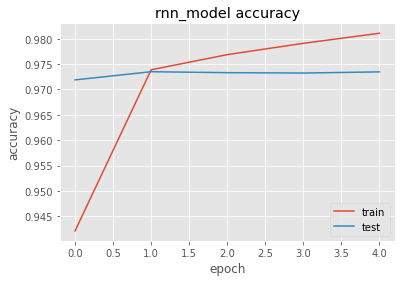

In [57]:
plt.plot(rnn_history.history['accuracy'])
plt.plot(rnn_history.history['val_accuracy'])
plt.title('rnn_model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc="lower right")
plt.show()

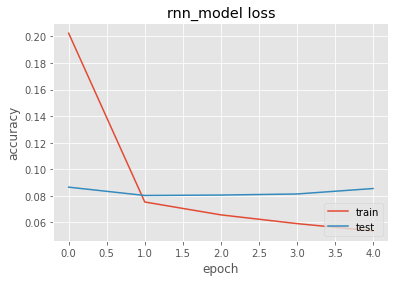

In [58]:
plt.plot(rnn_history.history['loss'])
plt.plot(rnn_history.history['val_loss'])
plt.title('rnn_model loss')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc="lower right")
plt.show()

## 2.LSTM.

In [59]:
lstm_model = Sequential()
lstm_model.add(Embedding(input_dim     = VOCABULARY_SIZE,         # vocabulary size - number of unique words in data
                         output_dim    = EMBEDDING_SIZE,          # length of vector with which each word is represented
                         input_length  = MAX_SEQ_LENGTH,          # length of input sequence
                         weights       = [embedding_matrix],     # word embedding matrix
                         trainable     = True                     # True - update embeddings_weight matrix
))
lstm_model.add(LSTM(64, return_sequences=True))
lstm_model.add(TimeDistributed(Dense(NUM_CLASSES, activation='softmax')))

- Compile model.

In [60]:
optimizer = Adam(learning_rate=0.01)
loss = CategoricalCrossentropy()

lstm_model.compile(optimizer=optimizer, loss=loss,
metrics=['accuracy'])

In [61]:
lstm_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 75, 300)           4793100   
                                                                 
 lstm (LSTM)                 (None, 75, 64)            93440     
                                                                 
 time_distributed_1 (TimeDis  (None, 75, 22)           1430      
 tributed)                                                       
                                                                 
Total params: 4,887,970
Trainable params: 4,887,970
Non-trainable params: 0
_________________________________________________________________


In [62]:
lstm_history = lstm_model.fit(
    x=X_train,
    y=y_train,
    validation_data=(X_dev,y_dev),
    batch_size= 256, 
    epochs=5,
    verbose=1
)

Epoch 1/5
106/106 [==============================] - 53s 476ms/step - loss: 0.2861 - accuracy: 0.9212 - val_loss: 0.0934 - val_accuracy: 0.9708
Epoch 2/5
106/106 [==============================] - 49s 464ms/step - loss: 0.0815 - accuracy: 0.9723 - val_loss: 0.0832 - val_accuracy: 0.9733
Epoch 3/5
106/106 [==============================] - 50s 468ms/step - loss: 0.0697 - accuracy: 0.9754 - val_loss: 0.0792 - val_accuracy: 0.9744
Epoch 4/5
106/106 [==============================] - 50s 470ms/step - loss: 0.0634 - accuracy: 0.9774 - val_loss: 0.0780 - val_accuracy: 0.9752
Epoch 5/5
106/106 [==============================] - 50s 471ms/step - loss: 0.0584 - accuracy: 0.9791 - val_loss: 0.0799 - val_accuracy: 0.9748


- Đồ thị học.

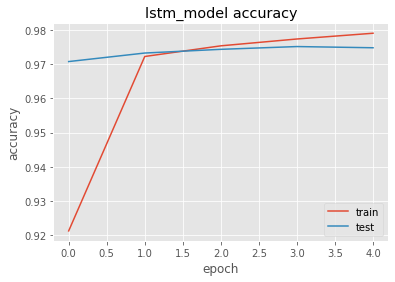

In [63]:
plt.plot(lstm_history.history['accuracy'])
plt.plot(lstm_history.history['val_accuracy'])
plt.title('lstm_model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc="lower right")
plt.show()

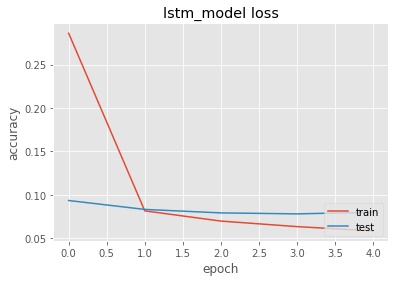

In [64]:
plt.plot(lstm_history.history['loss'])
plt.plot(lstm_history.history['val_loss'])
plt.title('lstm_model loss')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc="lower right")
plt.show()

In [65]:
lstm_model.evaluate(X_test, y_test)

67/67 [==============================] - 2s 24ms/step - loss: 0.0956 - accuracy: 0.9679


[0.09555505216121674, 0.967911958694458]

## 3. GRU.

In [66]:
# create architecture

gru_model = Sequential()
gru_model.add(Embedding(input_dim     = VOCABULARY_SIZE,
                        output_dim    = EMBEDDING_SIZE,
                        input_length  = MAX_SEQ_LENGTH,
                        weights       = [embedding_matrix],
                        trainable     = True
))
gru_model.add(GRU(64, return_sequences=True))
gru_model.add(TimeDistributed(Dense(NUM_CLASSES, activation='softmax')))

optimizer = Adam(learning_rate=0.1)
loss = CategoricalCrossentropy()

gru_model.compile(optimizer=optimizer, loss=loss,
metrics=['accuracy'])

gru_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 75, 300)           4793100   
                                                                 
 gru (GRU)                   (None, 75, 64)            70272     
                                                                 
 time_distributed_2 (TimeDis  (None, 75, 22)           1430      
 tributed)                                                       
                                                                 
Total params: 4,864,802
Trainable params: 4,864,802
Non-trainable params: 0
_________________________________________________________________


In [67]:
gru_history = gru_model.fit(
    x=X_train,
    y=y_train,
    validation_data=(X_dev,y_dev),
    batch_size= 256, 
    epochs=5,
    verbose=1
)

Epoch 1/5
106/106 [==============================] - 46s 412ms/step - loss: 0.3375 - accuracy: 0.9020 - val_loss: 0.1602 - val_accuracy: 0.9535
Epoch 2/5
106/106 [==============================] - 43s 409ms/step - loss: 0.1475 - accuracy: 0.9565 - val_loss: 0.1263 - val_accuracy: 0.9613
Epoch 3/5
106/106 [==============================] - 43s 402ms/step - loss: 0.1284 - accuracy: 0.9604 - val_loss: 0.1275 - val_accuracy: 0.9617
Epoch 4/5
106/106 [==============================] - 43s 404ms/step - loss: 0.1210 - accuracy: 0.9621 - val_loss: 0.1230 - val_accuracy: 0.9612
Epoch 5/5
106/106 [==============================] - 43s 402ms/step - loss: 0.1213 - accuracy: 0.9616 - val_loss: 0.1198 - val_accuracy: 0.9624


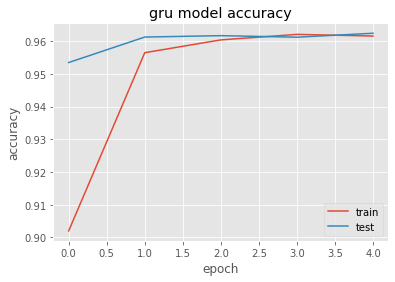

In [68]:
plt.plot(gru_history.history['accuracy'])
plt.plot(gru_history.history['val_accuracy'])
plt.title('gru model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc="lower right")
plt.show()

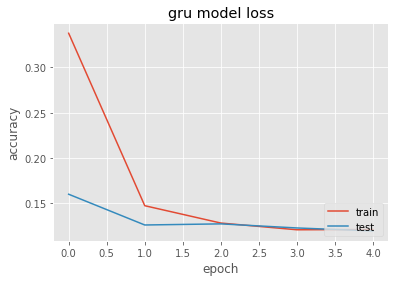

In [69]:
plt.plot(gru_history.history['loss'])
plt.plot(gru_history.history['val_loss'])
plt.title('gru model loss')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc="lower right")
plt.show()

## 4. Bidircectional LSTM.

In [70]:
# create architecture

bidirect_model = Sequential()
bidirect_model.add(Embedding(input_dim     = VOCABULARY_SIZE,
                             output_dim    = EMBEDDING_SIZE,
                             input_length  = MAX_SEQ_LENGTH,
                             weights       = [embedding_matrix],
                             trainable     = True
))
bidirect_model.add(Bidirectional(LSTM(64, return_sequences=True)))
bidirect_model.add(TimeDistributed(Dense(NUM_CLASSES, activation='softmax')))

In [71]:
optimizer = Adam(learning_rate=0.01)
loss = CategoricalCrossentropy()

bidirect_model.compile(optimizer=optimizer, loss=loss,
metrics=['accuracy'])

In [72]:
# check summary of model
bidirect_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 75, 300)           4793100   
                                                                 
 bidirectional (Bidirectiona  (None, 75, 128)          186880    
 l)                                                              
                                                                 
 time_distributed_3 (TimeDis  (None, 75, 22)           2838      
 tributed)                                                       
                                                                 
Total params: 4,982,818
Trainable params: 4,982,818
Non-trainable params: 0
_________________________________________________________________


In [73]:
bidirect_history= bidirect_model.fit(
    x=X_train,
    y=y_train,
    validation_data=(X_dev,y_dev),
    batch_size= 32, 
    epochs=5,
    verbose=1)

Epoch 1/5
844/844 [==============================] - 196s 227ms/step - loss: 0.1129 - accuracy: 0.9639 - val_loss: 0.0754 - val_accuracy: 0.9756
Epoch 2/5
844/844 [==============================] - 201s 238ms/step - loss: 0.0620 - accuracy: 0.9788 - val_loss: 0.0675 - val_accuracy: 0.9784
Epoch 3/5
844/844 [==============================] - 190s 225ms/step - loss: 0.0541 - accuracy: 0.9812 - val_loss: 0.0712 - val_accuracy: 0.9771
Epoch 4/5
844/844 [==============================] - 190s 225ms/step - loss: 0.0505 - accuracy: 0.9824 - val_loss: 0.0750 - val_accuracy: 0.9774
Epoch 5/5
844/844 [==============================] - 191s 227ms/step - loss: 0.0484 - accuracy: 0.9831 - val_loss: 0.0751 - val_accuracy: 0.9780


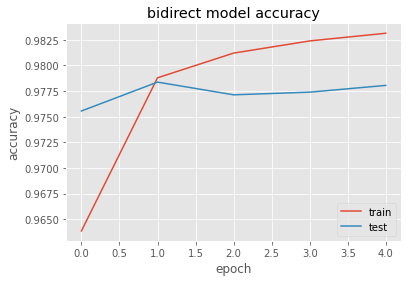

In [74]:
plt.plot(bidirect_history.history['accuracy'])
plt.plot(bidirect_history.history['val_accuracy'])
plt.title('bidirect model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc="lower right")
plt.show()

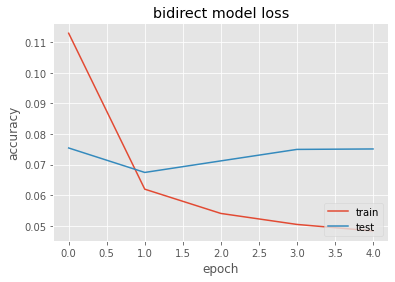

In [75]:
plt.plot(bidirect_history.history['loss'])
plt.plot(bidirect_history.history['val_loss'])
plt.title('bidirect model loss')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc="lower right")
plt.show()

# PHẦN 4: ĐÁNH GIÁ MÔ HÌNH.

## 1.Xây dựng các hàm cần thiết.

In [76]:

# Hàm dự đoán tagging trên 1 câu.
def pred_sentences(model,i):
  p = model.predict(np.array([X_test[i]]))
  p = np.argmax(p, axis=-1)
  y_true = np.argmax(y_test[i], axis=-1)
  print("{:15}{:5}\t {}\n".format("Word", "True", "Pred"))
  print("-" *30)
  for w, true, pred in zip(X_test[i], y_true, p[0]):
      print("{:15}{}\t{}".format(idx2word[w], tags[true], tags[pred]))

In [77]:
words[0]

'15974'

In [78]:
# Hàm xuất ra giá trị thức tế và giá trị dữ đoán.
def Out_put(model):
  y_test_padding=[]
  y_pred_padding=[]
  for i in range(len(X_test)):
    p = model.predict(np.array([X_test[i]]))
    p = np.argmax(p, axis=-1)
    y_true = np.argmax(y_test[i], axis=-1)
    p=list(p.reshape(-1,))
    y_true=list(y_true.reshape(-1,))

    y_test_padding+=y_true
    y_pred_padding+=p

  return y_test_padding,y_pred_padding

In [79]:
def Matrix(y_true,y_pred,title='Confusion_matris'):
  from sklearn.metrics import confusion_matrix
  array=confusion_matrix(y_true,y_pred)

  df_cm = pd.DataFrame(array)
  fig,ax =plt.subplots(figsize=(30,15))
  cmap=sns.diverging_palette(0,230,90,60,
    as_cmap=True)
  sns.heatmap(df_cm, annot=True,cmap=cmap,linecolor='black',linewidths=1,annot_kws={"fontsize":10})
  ytick =[i.upper() for i in list_labels]
  xick =[i.upper() for i in list_labels]

  ax.set_yticklabels(ytick, rotation =0);
  ax.set_xticklabels(xick, rotation =0);
  ax.set_title(title,fontsize=18);

  plt.show()

In [80]:
def Measure(y_true,y_pred):
  from sklearn.metrics import classification_report
  from sklearn.metrics import f1_score
  print("Độ đo f1 trên toàn bộ tập dữ liêu:")
  print("Micro : ",f1_score(y_true,y_pred , average='micro'))
  print("Macro : ",f1_score(y_true,y_pred, average='macro')) 

  print(classification_report(y_true,y_pred,target_names=list_labels))

In [81]:
def acc(y_test_padding,y_pred_padding):

  for i in range(len(list_labels)):
    count_test =0
    for y in y_test_padding:
      if y == i:
        count_test+=1

    count_pred =0
    for y in y_pred_padding:
      if y == i:
        count_pred+=1
    if count_test==0:
      print(list_labels[i]+":"+'0')
    else:
      print(list_labels[i]+":"+str(float(count_pred)/count_test))

In [82]:
# sort các tags theo index
list_sort= sorted(tag2idx.items(), key=lambda kv: kv[1])
list_labels = []
for i in list_sort:
    list_labels.append(i[0])
list_labels.remove("B")

## 2. RNN_Model.

In [83]:
a = rnn_model.evaluate(X_test,y_test)
print("Kết quả loss cuối cùng: ",a[0])
print("Kết quả accuracy cuối cùng: ",a[1])

67/67 [==============================] - 1s 14ms/step - loss: 0.1028 - accuracy: 0.9660
Kết quả loss cuối cùng:  0.10284824669361115
Kết quả accuracy cuối cùng:  0.9660000205039978


In [84]:
X_rnn,y_rnn = Out_put(rnn_model)

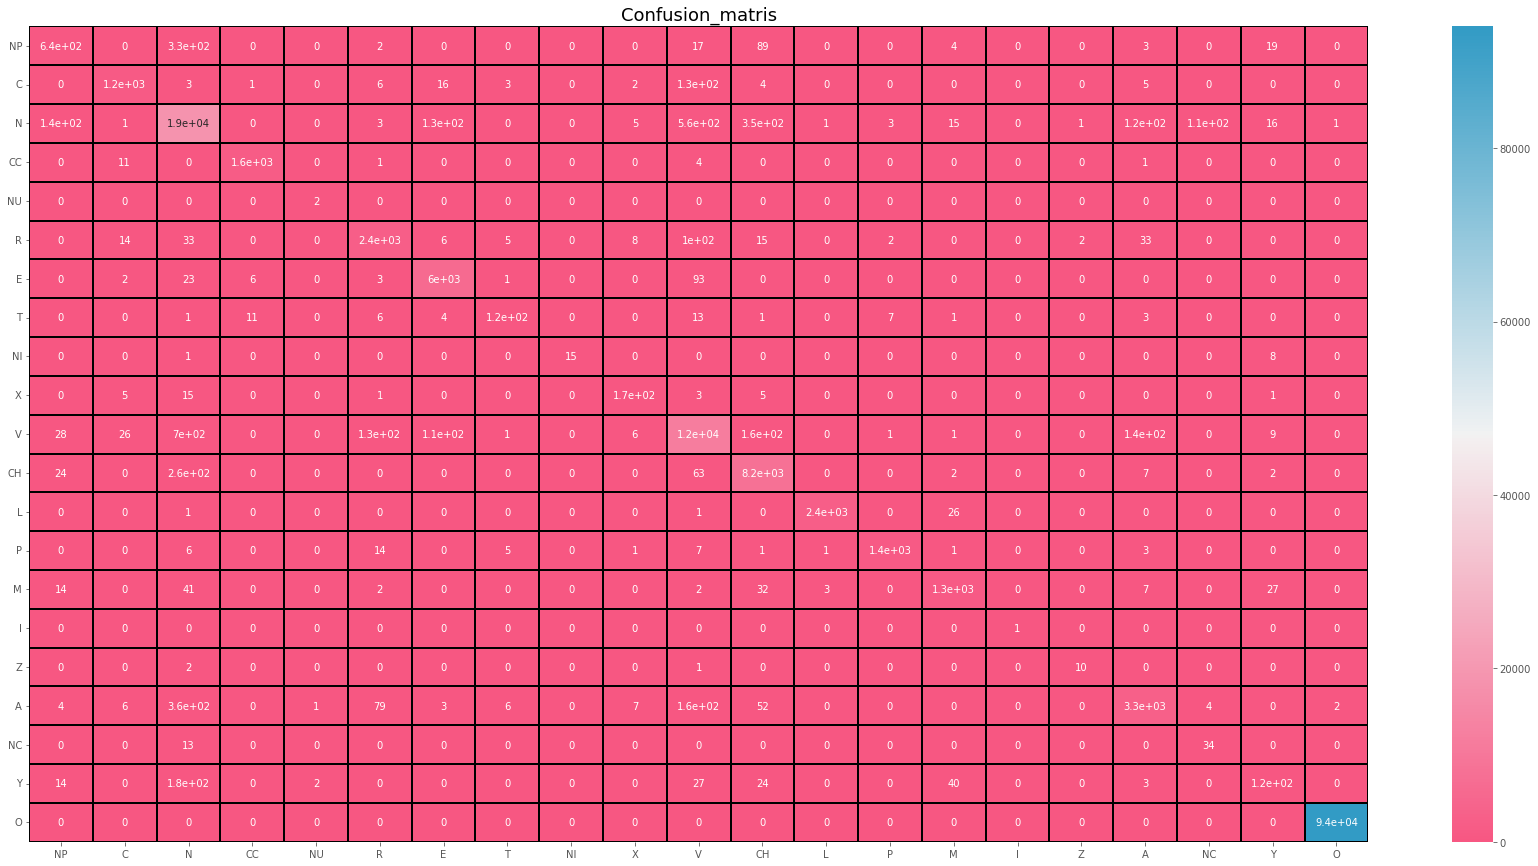

In [85]:

Matrix(X_rnn,y_rnn)

In [86]:
Measure(X_rnn,y_rnn)

Độ đo f1 trên toàn bộ tập dữ liêu:
Micro :  0.966
Macro :  0.8299784339084925
              precision    recall  f1-score   support

          Np       0.74      0.58      0.65      1104
           C       0.95      0.88      0.91      1375
           N       0.90      0.93      0.92     20011
          Cc       0.99      0.99      0.99      1661
          Nu       0.40      1.00      0.57         2
           R       0.91      0.92      0.91      2634
           E       0.96      0.98      0.97      6144
           T       0.85      0.71      0.77       163
          Ni       1.00      0.62      0.77        24
           X       0.86      0.85      0.85       202
           V       0.91      0.90      0.91     13324
          CH       0.92      0.96      0.94      8609
           L       1.00      0.99      0.99      2406
           P       0.99      0.97      0.98      1400
           M       0.94      0.91      0.93      1475
           I       1.00      1.00      1.00         1
   

In [87]:
acc(X_rnn,y_rnn)

Np:0.7853260869565217
C:0.9236363636363636
N:1.0259857078606767
Cc:1.0006020469596628
Nu:0
R:2.5
E:1.0098709187547457
T:1.0221354166666667
Ni:0.8404907975460123
X:0.625
V:0.995049504950495
CH:0.9909186430501351
L:1.043094436055291
P:0.9904405652535329
M:0.9814285714285714
I:0.9742372881355932
Z:1.0
A:1.0
Nc:0.9075757575757576
Y:3.1702127659574466
O:0.49029126213592233


## 3. LSTM_Model.

In [88]:
b = lstm_model.evaluate(X_test,y_test)
print("Kết quả loss cuối cùng: ",b[0])
print("Kết quả accuracy cuối cùng: ",b[1])

67/67 [==============================] - 2s 24ms/step - loss: 0.0956 - accuracy: 0.9679
Kết quả loss cuối cùng:  0.09555505216121674
Kết quả accuracy cuối cùng:  0.967911958694458


In [89]:
list_sort= sorted(tag2idx.items(), key=lambda kv: kv[1])
list_labels = []
for i in list_sort:
    list_labels.append(i[0])

In [90]:
X_lstm,y_lstm = Out_put(lstm_model)

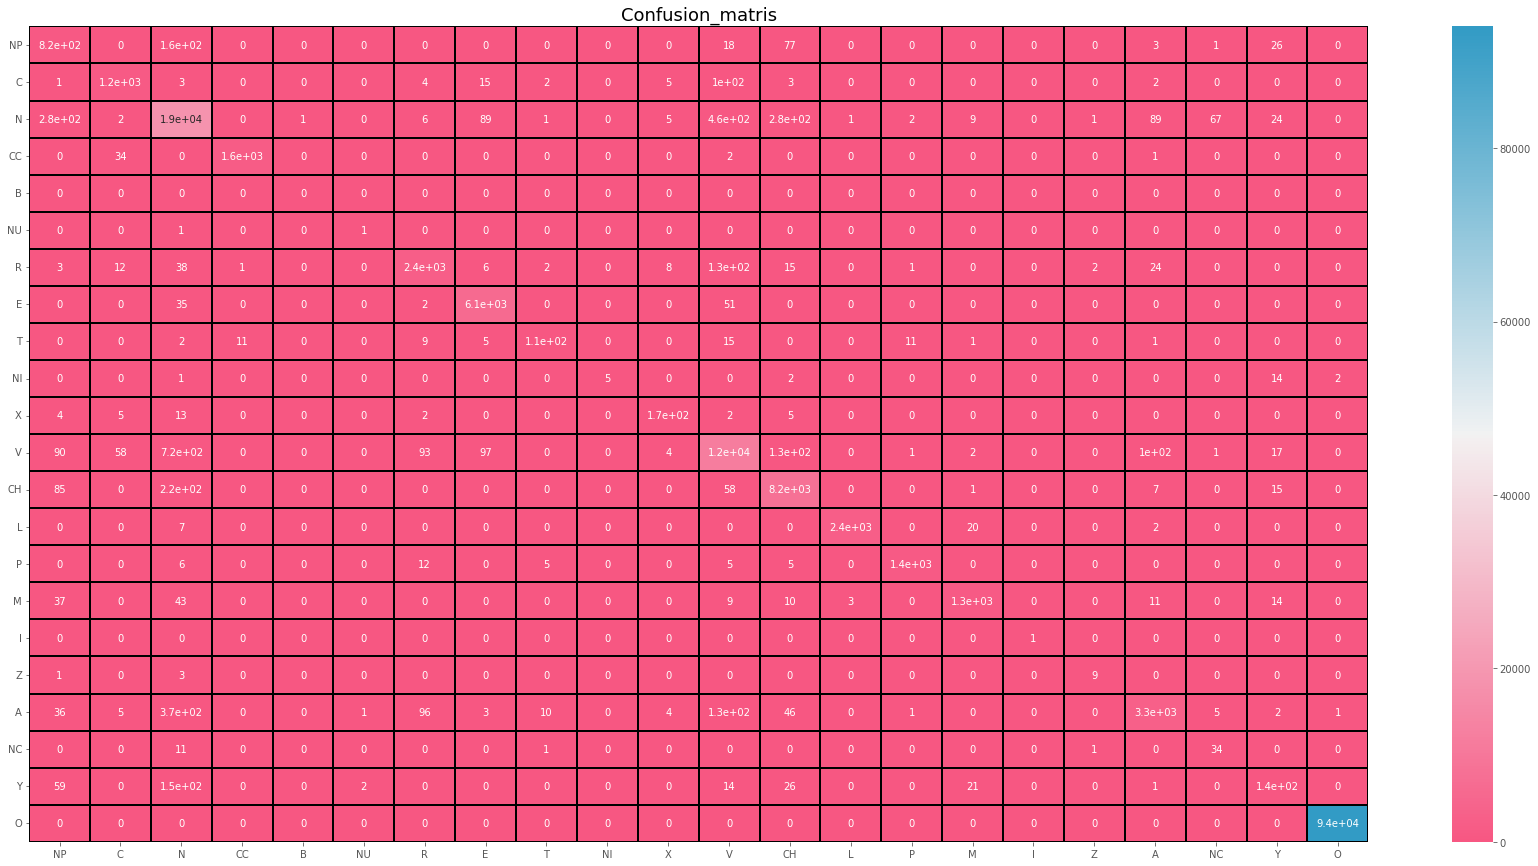

In [91]:
Matrix(X_lstm,y_lstm)

In [92]:
Measure(X_lstm,y_lstm)

Độ đo f1 trên toàn bộ tập dữ liêu:
Micro :  0.9679119496855346
Macro :  0.7647635022469846


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

          Np       0.58      0.74      0.65      1104
           C       0.91      0.90      0.91      1375
           N       0.91      0.93      0.92     20011
          Cc       0.99      0.98      0.99      1661
           B       0.00      0.00      0.00         0
          Nu       0.25      0.50      0.33         2
           R       0.91      0.91      0.91      2634
           E       0.97      0.99      0.98      6144
           T       0.84      0.66      0.74       163
          Ni       1.00      0.21      0.34        24
           X       0.87      0.85      0.86       202
           V       0.92      0.90      0.91     13324
          CH       0.93      0.95      0.94      8609
           L       1.00      0.99      0.99      2406
           P       0.99      0.98      0.98      1400
           M       0.96      0.91      0.94      1475
           I       1.00      1.00      1.00         1
           Z       0.69    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [93]:
acc(X_lstm,y_lstm)

Np:1.276268115942029
C:0.9847272727272727
N:1.0230873019839088
Cc:0.9849488260084287
B:0
Nu:2.0
R:0.9939255884586181
E:1.0206705729166667
T:0.7914110429447853
Ni:0.20833333333333334
X:0.9752475247524752
V:0.9759831882317622
CH:1.0250900220699268
L:0.9896093100581879
P:0.9878571428571429
M:0.9505084745762712
I:1.0
Z:1.0
A:0.8828282828282829
Nc:2.297872340425532
Y:0.616504854368932
O:1.0000319036933842


In [94]:
pred_sentences(rnn_model,3)

Word           True 	 Pred

------------------------------
với            E	E
tính_cách      N	N
là             V	V
một            M	M
phương_thức    N	N
thể_hiện       V	V
quyền_lực      N	N
chính_trị      N	N
và             Cc	Cc
quyền_lực      N	N
nhà_nước       N	N
,              CH	CH
hiệu_quả       N	N
của            E	E
nhà_nước       N	N
UNK            N	N
lại            R	R
phụ_thuộc      V	V
vào            E	E
những          L	L
cơ_sở          N	N
chính_trị      N	N
,              CH	CH
kinh_tế        N	N
-              CH	CH
xã_hội         N	N
và             Cc	Cc
văn_hoá        N	N
cụ_thể         A	A
của            E	E
mỗi            L	L
nước           N	N
,              CH	CH
làm            V	V
nên            V	V
nét            N	N
riêng_biệt     A	A
,              CH	CH
độc_đáo        A	A
của            E	E
nhà_nước       N	N
UNK            N	N
ở              E	E
mỗi            L	L
quốc_gia       N	N
.              CH	CH
PAD            O	O
PAD            O	O
PAD          

## 4. GRU_Model.

In [95]:
c = gru_model.evaluate(X_test,y_test)
print("Kết quả loss cuối cùng: ",c[0])
print("Kết quả accuracy cuối cùng: ",c[1])

67/67 [==============================] - 1s 21ms/step - loss: 0.1523 - accuracy: 0.9502
Kết quả loss cuối cùng:  0.15233679115772247
Kết quả accuracy cuối cùng:  0.950207531452179


In [96]:
X_gru,y_gru = Out_put(gru_model)

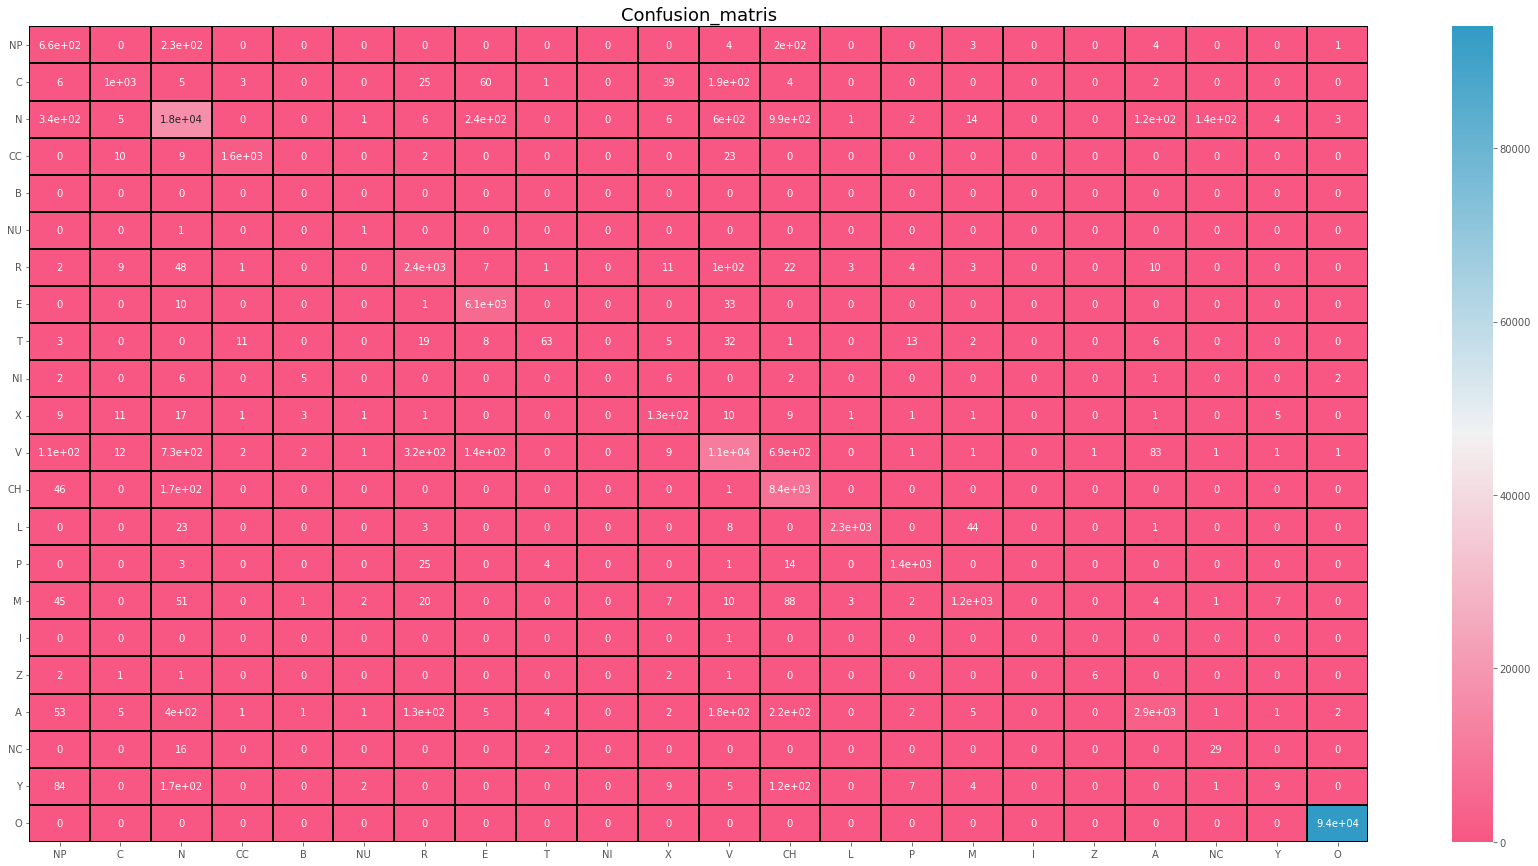

In [97]:
Matrix(X_gru,y_gru)

In [98]:
Measure(X_gru,y_gru)

Độ đo f1 trên toàn bộ tập dữ liêu:
Micro :  0.9502075471698114
Macro :  0.6224210526584631
              precision    recall  f1-score   support

          Np       0.48      0.59      0.53      1104
           C       0.95      0.76      0.84      1375
           N       0.90      0.88      0.89     20011
          Cc       0.99      0.97      0.98      1661
           B       0.00      0.00      0.00         0
          Nu       0.11      0.50      0.18         2
           R       0.81      0.91      0.86      2634
           E       0.93      0.99      0.96      6144
           T       0.84      0.39      0.53       163
          Ni       0.00      0.00      0.00        24
           X       0.58      0.65      0.61       202
           V       0.90      0.84      0.87     13324
          CH       0.78      0.97      0.87      8609
           L       1.00      0.97      0.98      2406
           P       0.98      0.97      0.97      1400
           M       0.94      0.84      0.89 

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1

In [99]:
acc(X_gru,y_gru)

Np:1.2355072463768115
C:0.7956363636363636
N:0.9707660786567388
Cc:0.9849488260084287
B:0
Nu:4.5
R:1.1233864844343204
E:1.06884765625
T:0.4601226993865031
Ni:0.0
X:1.1237623762376239
V:0.9314770339237466
CH:1.2491578580555234
L:0.9704904405652536
P:0.9892857142857143
M:0.8888135593220339
I:0.0
Z:0.5384615384615384
A:0.8042929292929293
Nc:3.702127659574468
Y:0.06553398058252427
O:1.0000957110801527


In [100]:
pred_sentences(gru_model,3)

Word           True 	 Pred

------------------------------
với            E	E
tính_cách      N	N
là             V	V
một            M	M
phương_thức    N	N
thể_hiện       V	V
quyền_lực      N	N
chính_trị      N	N
và             Cc	Cc
quyền_lực      N	N
nhà_nước       N	N
,              CH	CH
hiệu_quả       N	N
của            E	E
nhà_nước       N	N
UNK            N	CH
lại            R	R
phụ_thuộc      V	V
vào            E	E
những          L	L
cơ_sở          N	N
chính_trị      N	N
,              CH	CH
kinh_tế        N	N
-              CH	CH
xã_hội         N	N
và             Cc	Cc
văn_hoá        N	N
cụ_thể         A	A
của            E	E
mỗi            L	M
nước           N	N
,              CH	CH
làm            V	V
nên            V	V
nét            N	N
riêng_biệt     A	A
,              CH	CH
độc_đáo        A	A
của            E	E
nhà_nước       N	N
UNK            N	CH
ở              E	E
mỗi            L	M
quốc_gia       N	N
.              CH	CH
PAD            O	O
PAD            O	O
PAD        

## 5. Bidircectional_Model.

In [101]:
d = bidirect_model.evaluate(X_test,y_test)
print("Kết quả loss cuối cùng: ",d[0])
print("Kết quả accuracy cuối cùng: ",d[1])

67/67 [==============================] - 3s 40ms/step - loss: 0.0973 - accuracy: 0.9692
Kết quả loss cuối cùng:  0.09732823818922043
Kết quả accuracy cuối cùng:  0.9691697955131531


In [102]:
X_bidirect,y_bidirect = Out_put(bidirect_model)

In [103]:
# sort các tags theo index
list_sort= sorted(tag2idx.items(), key=lambda kv: kv[1])
list_labels = []
for i in list_sort:
    list_labels.append(i[0])


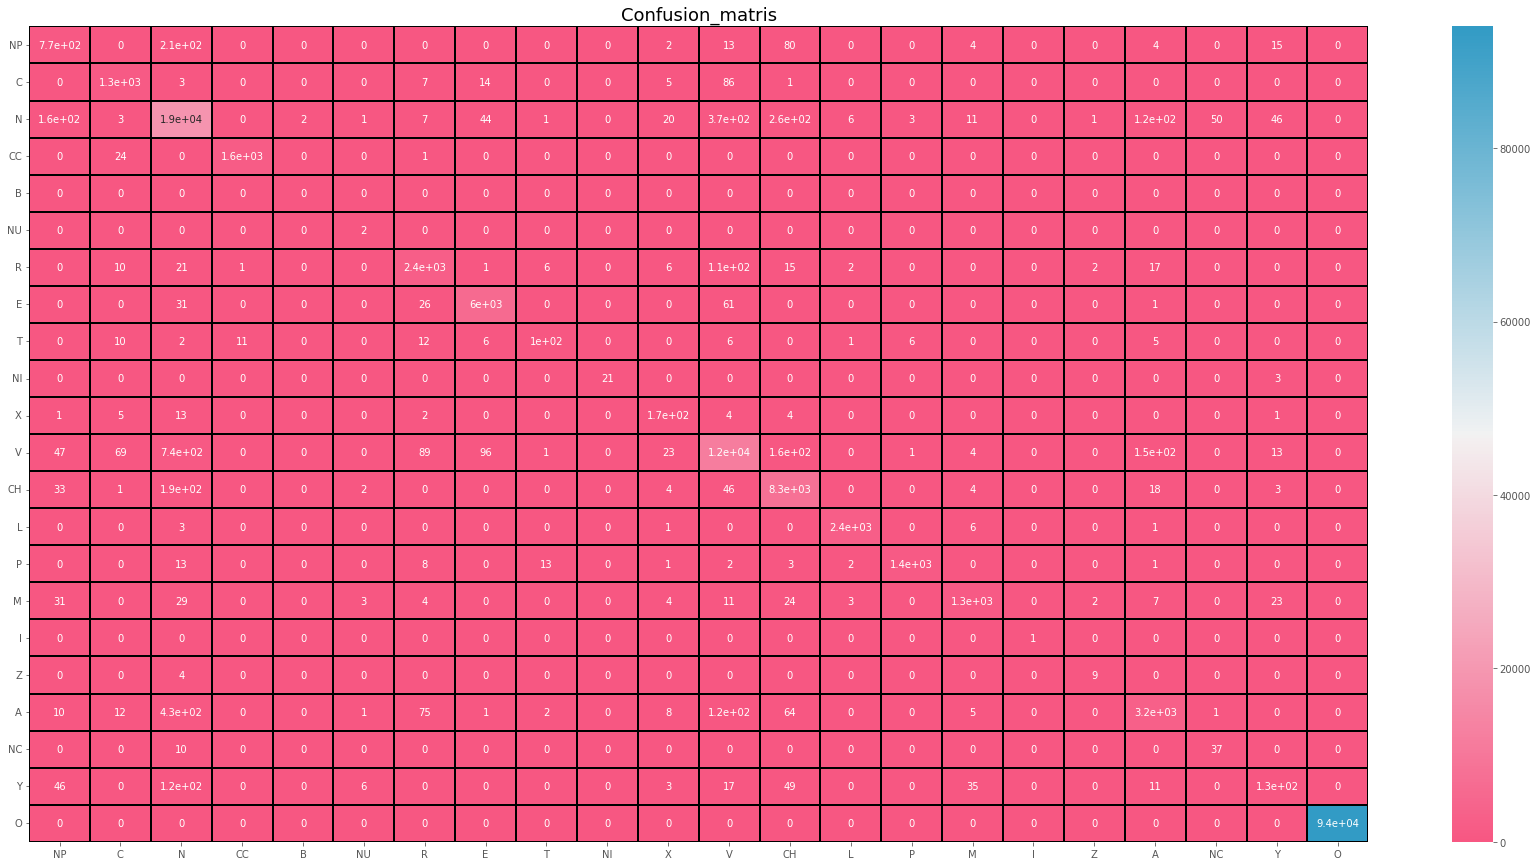

In [104]:
Matrix(X_bidirect,y_bidirect)

In [105]:
Measure(X_bidirect,y_bidirect)

Độ đo f1 trên toàn bộ tập dữ liêu:
Micro :  0.9691698113207547
Macro :  0.7866595769543728


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

          Np       0.70      0.70      0.70      1104
           C       0.90      0.92      0.91      1375
           N       0.91      0.94      0.93     20011
          Cc       0.99      0.98      0.99      1661
           B       0.00      0.00      0.00         0
          Nu       0.13      1.00      0.24         2
           R       0.91      0.93      0.92      2634
           E       0.97      0.98      0.98      6144
           T       0.82      0.64      0.72       163
          Ni       1.00      0.88      0.93        24
           X       0.69      0.85      0.76       202
           V       0.93      0.90      0.91     13324
          CH       0.93      0.96      0.95      8609
           L       0.99      1.00      0.99      2406
           P       0.99      0.97      0.98      1400
           M       0.95      0.90      0.93      1475
           I       1.00      1.00      1.00         1
           Z       0.64    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [106]:
acc(X_bidirect,y_bidirect)

Np:0.9927536231884058
C:1.013090909090909
N:1.0357303483084304
Cc:0.9921733895243829
B:0
Nu:7.5
R:1.0148063781321184
E:1.0069986979166667
T:0.7791411042944786
Ni:0.875
X:1.2326732673267327
V:0.9593965776043231
CH:1.0419328609594611
L:1.0012468827930174
P:0.9764285714285714
M:0.9511864406779661
I:1.0
Z:1.0769230769230769
A:0.8997474747474747
Nc:1.872340425531915
Y:0.5631067961165048
O:1.0


In [107]:
pred_sentences(bidirect_model,3)

Word           True 	 Pred

------------------------------
với            E	E
tính_cách      N	N
là             V	V
một            M	M
phương_thức    N	N
thể_hiện       V	V
quyền_lực      N	N
chính_trị      N	N
và             Cc	Cc
quyền_lực      N	N
nhà_nước       N	N
,              CH	CH
hiệu_quả       N	N
của            E	E
nhà_nước       N	N
UNK            N	N
lại            R	V
phụ_thuộc      V	V
vào            E	E
những          L	L
cơ_sở          N	N
chính_trị      N	N
,              CH	CH
kinh_tế        N	N
-              CH	CH
xã_hội         N	N
và             Cc	Cc
văn_hoá        N	N
cụ_thể         A	A
của            E	E
mỗi            L	L
nước           N	N
,              CH	CH
làm            V	V
nên            V	C
nét            N	N
riêng_biệt     A	A
,              CH	CH
độc_đáo        A	A
của            E	E
nhà_nước       N	N
UNK            N	Np
ở              E	E
mỗi            L	M
quốc_gia       N	N
.              CH	CH
PAD            O	O
PAD            O	O
PAD         